<a id='sec0'></a>

# Writing n-class word extraction functions

<a href='#sec1'><b>1. Extraction by frequency differences between classes</b></a>
   - Thresholds for minimum fraction of documents appearing or per-doc frequency
   - Threshold with absolute difference (by subtraction) or relative/fold difference (by division)

<a href='#sec2'><b>2. Extraction by exclusive appearances in certain classes</b></a>
   - Threshold for minimum fraction of documents appearing or per-doc frequency
   
<a href='#sec3'><b>3. Classification by Random Forest Classifier</b></a>
   1. <a href='#sec3_1'>RFC with exclusive words</a>
   2. <a href='#sec3_2'>RFC with words selected by relative difference - fraction of docs appearing</a>

In [120]:
import csv
import json
import random
import re
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import xgboost as xgb
import importlib as imp
import feature_engineering.frequency_selection as fefs

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
#from gensim import corpora, matutils, models, similarities
#from nltk import PorterStemmer
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

<b>Import and pre-process data</b>

In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])
train = class_train.merge(text_train, on='ID')

# create class label container
class_labels = []
for i in range(9):
    class_labels.append('class' + str(i+1))

<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: Dep

In [3]:
with open('./data/classified_docs.json') as f1:
    classified_docs = json.load(f1)

with open('./data/classified_tokenized_docs.json') as f2:
    classified_tokenized_docs = json.load(f2)

with open('./data/classified_texts.json') as f3:
    classified_texts = json.load(f3)

with open('./data/classified_tokenized_texts.json') as f4:
    classified_tokenized_texts = json.load(f4)

with open('./data/average_per_document_appearances.json') as f5:
    ave_perdoc_apps = json.load(f5)
    
with open('./data/fraction_of_documents_with_appearance.json') as f6:
    app_freqs = json.load(f6)

with open("./data/unclassified_tokenized_docs.csv", "r") as f:
    reader = csv.reader(f)
    unclassified_tokenized_docs = list(reader)

perdoc_apps = pd.DataFrame(ave_perdoc_apps).fillna(value=0)

In [4]:
%%time
fracdocs = pd.DataFrame(app_freqs).fillna(value=0)
n = 3000

top_words = []
for i in range(9):
    tops = fracdocs[class_labels[i]].sort_values(ascending=False).head(n)
    top_words.append(list(tops.index))

overlap1 = set(top_words[0])
for lis in top_words[1:]:
    overlap1.intersection_update(lis)
print('# intersecting words among top%d appearing words in each class: ', len(overlap1))
    
remove_list = []
for i in range(9):
    remove_words = [word for word in overlap1 \
                    if word in fracdocs[class_labels[i]] \
                    if fracdocs[class_labels[i]][word] > 0.5]
    remove_list.append(list(remove_words))

overlap2 = set(remove_list[0])
for lis in remove_list[1:]:
    overlap2.intersection_update(lis)
print('# intersecting words with >50% appearance: ', len(overlap2))

fracdocs_update1 = fracdocs.copy()
fracdocs_update1 = fracdocs_update1.drop(overlap2)
print('Table shape before removal: ', fracdocs.shape)
print('Table shape after removal:  ', fracdocs_update1.shape)

# intersecting words among top%d appearing words in each class:  1391
# intersecting words with >50% appearance:  287
Table shape before removal:  (125448, 9)
Table shape after removal:   (125161, 9)
CPU times: user 350 ms, sys: 5.03 ms, total: 355 ms
Wall time: 355 ms


<a id='sec1'></a>
<b>Extraction by fold difference  in frequency between classes</b>
(<a href='#sec0'>Back to top</a>)

In [5]:
%%time
n_class_words = fefs.getNClassWords(fracdocs_update1, doc_type='fraction_of_docs', mode='relative',
                                min_frequency=0.35, min_difference=1.4, print_result=True)
print('\n')
n_class_words = fefs.getNClassWords(fracdocs_update1, doc_type='fraction_of_docs', mode='absolute',
                                min_frequency=0.35, min_difference=0.2, print_result=True)
print('\n')
n_class_words = fefs.getNClassWords(perdoc_apps, doc_type='per_doc_frequency', mode='relative',
                                min_frequency=2, min_difference=5, print_result=True)
print('\n')
n_class_words = fefs.getNClassWords(perdoc_apps, doc_type='per_doc_frequency', mode='absolute',
                                min_frequency=2, min_difference=3, print_result=True)

====== n-class words extractions by relative differecne ======
Input Type: fraction_of_docs
Minimum Difference = 1.40
Minimum Frequency = 0.35
# of words in one_class_words: 312
# of words in two_class_words: 117
# of words in three_class_words: 11
# of words in four_class_words: 14
# of words in five_class_words: 11
# of words in six_class_words: 6
# of words in seven_class_words: 25
# of words in eight_class_words: 69
# of words in other_words: 124581
Total # of words: 125146


====== n-class words extractions by absolute differecne ======
Input Type: fraction_of_docs
Minimum Difference = 0.20
Minimum Frequency = 0.35
# of words in one_class_words: 186
# of words in two_class_words: 56
# of words in three_class_words: 2
# of words in four_class_words: 2
# of words in five_class_words: 1
# of words in six_class_words: 1
# of words in seven_class_words: 2
# of words in eight_class_words: 16
# of words in other_words: 124885
Total # of words: 125151


====== n-class words extractions by

<a id='sec2'></a>
<b>Extraction by exclusive appearance in certain classes</b>
(<a href='#sec0'>Back to top</a>)

In [6]:
%%time
min_freq = 0.15
n_class_words_excl = fefs.getNClassExclusiveWords(fracdocs_update1, min_frequency=min_freq)

===== n-class words extractions by exclusive appearances =====
Minimum Frequency = 0.150000
# of words in one_class_words: 264
# of words in two_class_words: 4
# of words in three_class_words: 0
# of words in four_class_words: 0
# of words in five_class_words: 0
# of words in six_class_words: 0
# of words in seven_class_words: 0
# of words in eight_class_words: 3
# of words in other_words: 124890
Total # of words: 125161
CPU times: user 9.06 s, sys: 31.7 ms, total: 9.1 s
Wall time: 9.02 s


<a id='sec3'></a>
# 3. Classification with Random Forest Classifier
(<a href='#sec0'>Back to top</a>)

In [7]:
select_words = fefs.selectNClassWords(n_class_words_excl, 2)
print(len(select_words))

268


In [8]:
vec_result = fefs.myVectorizer(unclassified_tokenized_docs, select_words, type='count')
vec_result['matrix'].shape

(3321, 268)

In [22]:
mat = vec_result['matrix']
zero_ind = list(np.where(~mat.any(axis=1))[0])
print(len(zero_ind))

3288


In [9]:
%%time
y = np.array(class_train.Class).astype(int).ravel()

rfc = RandomForestClassifier(n_estimators=100, max_depth=50,
                             n_jobs=7, random_state=33)

fefs.RFC_NClassWords(unclassified_tokenized_docs, fracdocs_update1, y, 
                    n_class=3, doc_type='fraction_of_docs', extract_mode='relative', 
                    min_difference=1.4, min_frequency=0.35, vector_type='tfidf',
                    test_size=0.15, random_state=None,
                    rfc=rfc)

Extracting words...
440 words extracted...
Vectorizating texts...
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.613
 - Log Loss: 1.376
CPU times: user 14.7 s, sys: 103 ms, total: 14.8 s
Wall time: 13.9 s


In [10]:
%%time
y = np.array(class_train.Class).astype(int).ravel()

rfc = RandomForestClassifier(n_estimators=100, max_depth=50,
                             n_jobs=7, random_state=33)

fefs.RFC_NClassExclusiveWords(unclassified_tokenized_docs, fracdocs_update1, y, 
                    n_class=3, min_frequency=0.15, vector_type='tfidf',
                    test_size=0.15, random_state=None,
                    rfc=rfc)

Extracting words...
268 words extracted...
Vectorizating texts...
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.301
 - Log Loss: 1.801
CPU times: user 12.9 s, sys: 60.8 ms, total: 13 s
Wall time: 12.9 s


In [75]:
import feature_engineering.frequency_selection as fefs
imp.reload(feature_engineering.frequency_selection)

<module 'feature_engineering.frequency_selection' from '/home/ryohayama/python_current/kaggle_sloan/feature_engineering/frequency_selection.py'>

In [82]:
%%time

y = np.array(class_train.Class).astype(int).ravel()

rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=7, random_state=33)

result = fefs.RFC_NClassWordsPlus(unclassified_tokenized_docs, fracdocs_update1, y, exclusive_class=8,
                    n_class=8, doc_type='fraction_of_docs', extract_mode='relative', 
                    min_difference=1.4, min_frequency=0.35, min_excl_frequency=0.15,
                    vector_type='count', test_size=0.15, random_state=345, verbose=True,
                    rfc=rfc)

Extracting words...
836 words extracted...
Vectorizating texts...
5 of 3321 entries not covered by the extracted words
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.633
 - Log Loss: 1.073
CPU times: user 24.9 s, sys: 91.2 ms, total: 25 s
Wall time: 23.6 s


In [148]:
X = result['feature_matrix']
zero_ind = list(np.where(~X.any(axis=1))[0])
print(len(zero_ind))
print(zero_ind)

5
[1109, 1277, 1407, 1639, 2755]


0.000768525118028
836


(array([ 0.3708134 ,  0.43301435,  0.53349282,  0.6291866 ,  0.70095694,
         0.76435407,  0.83014354,  0.86363636,  0.87679426,  0.90191388,
         0.92105263,  0.93181818,  0.94258373,  0.95334928,  0.95574163,
         0.96172249,  0.96291866,  0.96770335,  0.97129187,  0.97368421,
         0.97488038,  0.97727273,  0.98205742,  0.98444976,  0.98564593,
         0.98564593,  0.98564593,  0.98803828,  0.98923445,  0.99043062,
         0.99162679,  0.99401914,  0.99401914,  0.99401914,  0.99521531,
         0.99521531,  0.99521531,  0.99641148,  0.99641148,  0.99641148,
         0.99641148,  0.99641148,  0.99641148,  0.99641148,  0.99641148,
         0.99641148,  0.99760766,  0.99880383,  0.99880383,  1.        ]),
 array([ 0.        ,  0.00028863,  0.00057726,  0.0008659 ,  0.00115453,
         0.00144316,  0.00173179,  0.00202043,  0.00230906,  0.00259769,
         0.00288632,  0.00317495,  0.00346359,  0.00375222,  0.00404085,
         0.00432948,  0.00461811,  0.00490675,  0

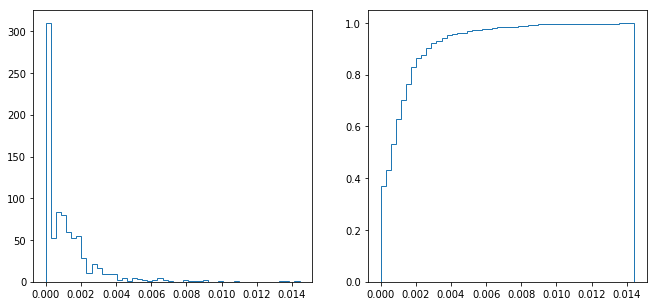

In [149]:
clf = result['classifier']
importances = clf.feature_importances_
print(np.percentile(importances, 50))
print(len(importances))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
ax1.hist(importances, bins=50, histtype='step')
ax2.hist(importances, bins=50, normed=1, cumulative=1, histtype='step')

In [150]:
selection_ind = np.argwhere(importances > np.percentile(importances, 95)).ravel()
selectX = X[:, selection_ind]
print('Original: ', X.shape)
print('Select: ',selectX.shape)

Original:  (3321, 836)
Select:  (3321, 42)


In [151]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=12, n_jobs=7, random_state=33)
X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15, random_state=345)
rfc.fit(X_train, y_train)
print(accuracy_score(y_test, rfc.predict(X_test)))
print(log_loss(y_test, rfc.predict_proba(X_test), labels=list(range(1, 10))))

0.619238476954
1.09512466424


In [152]:
new_words = [key for key, value in result['feature_ids'].items() if value in selection_ind]

In [157]:
import feature_engineering.frequency_selection as fefs
imp.reload(feature_engineering.frequency_selection)


y = np.array(class_train.Class).astype(int).ravel()

rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=7, random_state=33)

result2 = fefs.RFC_CustomWords(unclassified_tokenized_docs, fracdocs_update1, y, new_words,
                    vector_type='count', test_size=0.15, random_state=None, verbose=True,
                    rfc=rfc)

42 words selected...
Vectorizating texts...
15 of 3321 entries not covered by the extracted words
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.605
 - Log Loss: 1.110


## PCA & LDA

In [141]:
X = selectX

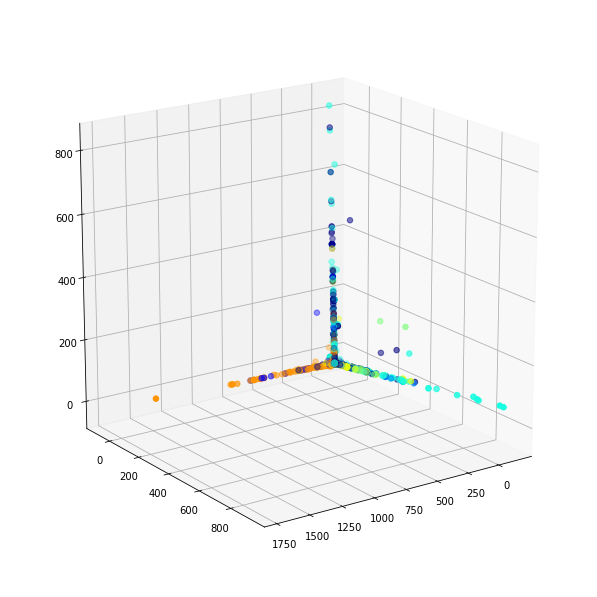

In [142]:
# Create a new table with ID as index
pca_table1 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X)
pca_table1['x'] = pca.transform(X).T[0]
pca_table1['y'] = pca.transform(X).T[1]
pca_table1['z'] = pca.transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table1.x, pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=30, cmap = cm.jet)

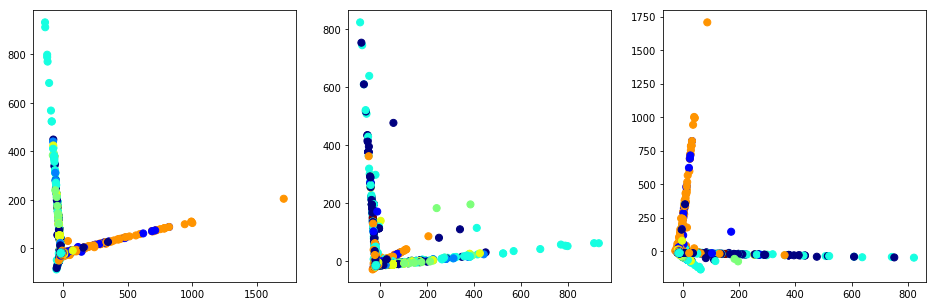

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table1.x, pca_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table1.z, pca_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

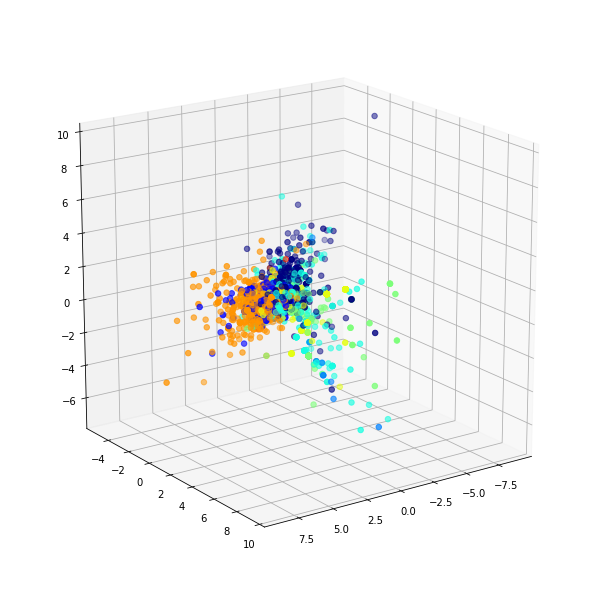

In [144]:
# Create a new table with ID as index
lda_table1 = pd.DataFrame(index=class_train.ID)
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X, y)
lda_table1['x'] = lda.transform(X).T[0]
lda_table1['y'] = lda.transform(X).T[1]
lda_table1['z'] = lda.transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(lda_table1.x, lda_table1.y, lda_table1.z, c=class_train['Class'], marker = 'o', s=30, cmap = cm.jet)

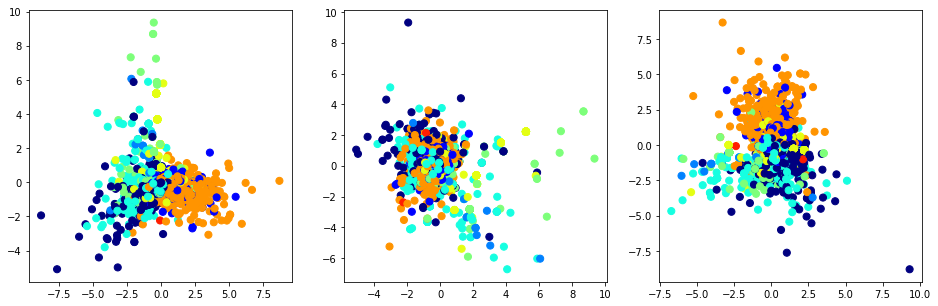

In [145]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(lda_table1.x, lda_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(lda_table1.y, lda_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(lda_table1.z, lda_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

In [146]:
%%time
lda = LinearDiscriminantAnalysis()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print(X_train.shape, X_train_lda.shape)
print(X_test.shape, X_test_lda.shape)

rfc.fit(X_train_lda, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_lda))
lloss = log_loss(y_test, rfc.predict_proba(X_test_lda), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 42) (2822, 8)
(499, 42) (499, 8)
Accuracy 0.591
Log Loss 1.982
CPU times: user 575 ms, sys: 19.1 ms, total: 594 ms
Wall time: 376 ms
